<a href="https://colab.research.google.com/github/thual/ASID-Lorenz/blob/main/TDLorenz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Methods comparisons for the Lorenz model







We compare four data assimilation methods:

*   Method 0 : Chain of 3DVar with $\underline{\underline B}$ constant
*   Method 1 : Chain of 3DVar with $\underline{\underline B}=\underline{\underline A}$ 
*   Method 2 : Kalman Filter with $\underline{\underline B}=\underline{\underline M}\;\underline{\underline A}\;\underline{\underline M}^T$ 
*   Method 3 : Ensemble Kalman Filter 

We compare four extraction operator:

*   Operator 0 :  ${\cal H}(\underline x) = x_1 = X$
*   Operator 1 :  ${\cal H}(\underline x) = x_2 = Y$
*   Operator 2 :  ${\cal H}(\underline x) = x_3 = Z$
*   Operator 3 :  ${\cal H}(\underline x) = \underline x^2 = X^2+Y^2+Z^2$


**References:**

*   O. Thual, "[Introduction to Data Assimilation for Scientists and Engineers](http://pedagotech.inp-toulouse.fr/130202/co/module_idase.html)", Open Learn. Res. Ed. INP 0202 (2013) 6h


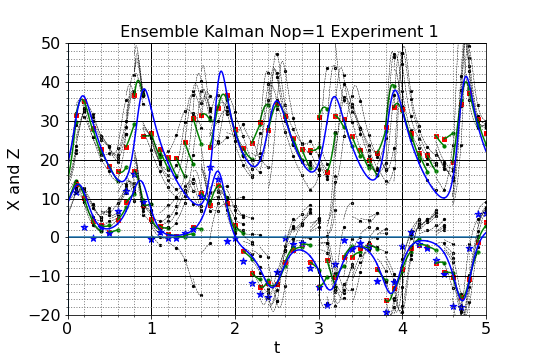

# Compilation of the subroutines

Execute first the code below to define the functions!

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint


def inifig(xdim=7.5,ydim=5,xaxe=0,yaxe=0,xlab='x',ylab='y'):
    # Standard figure initialization with grids
    plt.figure(figsize=(xdim,ydim))
    plt.grid(color='black', axis='x', linestyle='-', linewidth=1)        
    plt.grid(color='black', axis='y', linestyle='-', linewidth=1)        
    plt.minorticks_on()
    plt.grid(which='minor',color='grey', axis='x', linestyle=':', linewidth=1)        
    plt.grid(which='minor',color='grey', axis='y', linestyle=':', linewidth=1)        
    plt.axvline(xaxe)
    plt.axhline(yaxe)
    plt.xlabel(xlab,fontsize=16 )
    plt.ylabel(ylab,fontsize=16)
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)    
    

def F(x,t,par):
    X=x[0]; Y=x[1]; Z=x[2]
    sig=par[0]; rho=par[1]; bet=par[2]
    FX=-sig*X+sig*Y
    FY=rho*X-Y-X*Z
    FZ=X*Y-bet*Z
    return [FX, FY, FZ]

def FdF(xdx,t,par):
    X=xdx[0]; Y=xdx[1]; Z=xdx[2]
    dX=xdx[3]; dY=xdx[4]; dZ=xdx[5]
    sig=par[0]; rho=par[1]; bet=par[2]
    # Non linear trajectory
    FX=-sig*X+sig*Y
    FY=rho*X-Y-X*Z
    FZ=X*Y-bet*Z
    # Linearized trajectory
    FdX=-sig*dX+sig*dY
    FdY=rho*dX-dY-X*dZ-dX*Z
    FdZ=X*dZ+dX*Y-bet*dZ   
    return [FX, FY, FZ, FdX, FdY, FdZ]

class Traj:
    def __init__(self):
        self.par=[10,28,8/3]
        self.t0=0
        self.tf=10
        self.xini=[10,15,20] 
        self.nt=51
        
    def ode(self):
        t0=self.t0; tf=self.tf; nt=self.nt
        t=np.linspace(t0,tf,nt+1)   
        xini=self.xini; par=self.par
        sol=odeint(F,xini,t,(par,))
        return t,sol     

    def odeM(self):
        t0=self.t0; tf=self.tf; nt=self.nt
        t=np.linspace(t0,tf,nt+1)   
        xini=self.xini; par=self.par
        # Tangent linear operator
        dxini=np.zeros(3)
        uuM=np.zeros([3,3])
        for i in range(3):
            dxini=np.zeros(3)
            dxini[i]=1
            xdxini=np.concatenate((xini, dxini), axis=None)
            soldx=odeint(FdF,xdxini,t,(par,))
            sol=soldx[:,0:3]; uuM[:,i]=soldx[-1,3:7];
        return t,sol,uuM 
        
def transitory(flag):   
    # Transitory        
    Ttr=Traj(); Ttr.nt=1000
    t,sol=Ttr.ode()
    ux_fin=np.array(sol[-1,:]).reshape(3,1)
    if flag:
        Xt=sol[:,0]; Yt=sol[:,1]; Zt=sol[:,2]; 
        
        # X(t)
        inifig(xaxe=0,xlab='t',ylab='X')
        plt.plot(t,Xt,'b')
        plt.savefig('TrueX'+'.pdf')
        plt.show(); plt.close()
        
        # X Z
        inifig(xaxe=0,xlab='X',ylab='Z')
        plt.plot(Xt,Zt,'b')
        plt.savefig('TrueXZ'+'.pdf')
        plt.show(); plt.close()
        
        # X Y Z
        plt.figure()
        ax = plt.axes(projection='3d')
        ax.plot3D(Xt,Yt,Zt,'b')
        plt.savefig('TrueXYZ'+'.pdf')
        plt.show(); plt.close()
    return ux_fin

class Blue:
    def __init__(self,N,M):
        self.N=N
        self.M=M
        self.uuB=uuB0
        self.uuR=uuR
        self.uxb=np.zeros((N,1))
        self.ud=np.zeros((M,1))
        self.uuG=np.eye(M,N)
        self.uuI=np.eye(N,N)
        
    def analysis(self):
        uuB=self.uuB; uuR=self.uuR; uuG=self.uuG
        ud=self.ud; uxb=self.uxb
        uuK=uuB@uuG.T@np.linalg.inv(uuG@uuB@uuG.T+uuR)
        uxa=uxb+uuK@ud
        return uxa
    
    def matA(self):
        uuB=self.uuB; uuR=self.uuR; uuG=self.uuG
        uuI=self.uuI
        uuK=uuB@uuG.T@np.linalg.inv(uuG@uuB@uuG.T+uuR)
        uuA=(uuI-uuK@uuG)@uuB
        return uuA

    
class enBlue:
    def __init__(self,N,M):
        self.N=N
        self.M=M        
        self.uuI=np.eye(N,N)
        
    def ensemble(self,tobs,uxbrk):
        Tr=Traj(); Tr.nt=nt;
        Tr.t0=tobs; Tr.tf=tobs+dt;  
        # Trajectories of the members
        uxbrknext=np.zeros([3,R])
        uybrk=np.zeros(R)
        for r in range(R):
            Tr.xini=uxbrk[:,r].reshape(3)         
            t, sol=Tr.ode()
            uxr=sol[-1]
            uxbrknext[:,r]=uxr
            uybrk[r]=Op.cH(uxr)
            # Plot Nblack curves
            if r%RsNblack==0:
                Xrk=sol[:,0]; Zrk=sol[:,2]; 
                plt.plot(t,Xrk,'--',color='black',linewidth=.5)  
                plt.plot(t,Zrk,'--',color='black',linewidth=.5)  
                plt.scatter(t[-1],Xrk[-1],marker='o',color='black',s=5)
                plt.scatter(t[-1],Zrk[-1],marker='o',color='black',s=5)
        uxbrk=uxbrknext.copy()
        #uybrk=Op.cH(uxbrk)
        uxbk=(1/R)*np.sum(uxbrk,axis=1).reshape(3,1)
        uybk=Op.cH(uxbk)
        return uxbrk,uybrk, uxbk,uybk
       
        
    def analysis(self,uxbrk,uybrk,uxbk,uybk,uyok):
        ## Computation of the analysis with the ensemble method
        BGT=(1/R)*((uxbrk-uxbk)@(uybrk-uybk).T).reshape(3,1)
        GBGT=(1/R)*((uybrk-uybk)@(uybrk-uybk).T).reshape(1,1)
        uuK=BGT@np.linalg.inv(GBGT+uuR)
        uxbrk=uxbrk+uuK@(uyok-uybk)
        uxak=(1/R)*np.sum(uxbrk,axis=1)
        return uxbrk,uxak,uuK,BGT    
    
    def matA(self,uuK,BGT):
        uuI=self.uuI
        uuA=uuI-uuK@(BGT).T        
        return uuA
 

class obsOp:
    def __init__(self,Nop):
        self.Nop=Nop
        
    def cH(self,ux):
        Nop=self.Nop
        if Nop==0: H=ux[0]      
        if Nop==1: H=ux[1]      
        if Nop==2: H=ux[2]      
        if Nop==3: H=.1*ux.T@ux      
        return H 
   
    def cH_lin(self,ux):
        Nop=self.Nop
        if Nop==0: Hlin=np.array([[1,0,0]])
        if Nop==1: Hlin=np.array([[0,1,0]])
        if Nop==2: Hlin=np.array([[0,0,1]])     
        if Nop==3: Hlin=.2*ux.reshape(1,3)  
        return Hlin         
   

def Chain(i,method):
    # Chain of BLUE with constant B
    print("Experiment "+str(i)+" =======")
    inifig(xlab='t',ylab='X and Z')  
    
    # Initializations : xt_k xa_k  t_obs ...
    uxak=uxak0.copy()
    uxbk=uxbk0.copy()
    tobs=tobs0
    uxbrk=uxbrk0.copy() # Ensemble method
   
    # BLUE
    TroiD=Blue(3,1) # Creation of the 3DVar object
    TroiD.uuR=uuR
    TroiD.uuG=Op.cH_lin(uxbk)
    uuA=uuB0
 
    # Loop in the observation times
    for k in range(1,K+1):
       
        # Background
        Tb=Traj(); Tb.nt=nt;
        Tb.t0=tobs; Tb.tf=tobs+dt;  
        Tb.xini=uxak.reshape(3)
        t,sol,uuM=Tb.odeM()
        uxbk=np.array(sol[-1,:]).reshape(3,1)
        uybk=Op.cH(uxbk)
        Xb=sol[:,0]; Zb=sol[:,2]; 
        # Background trajectory Xb(t)
        plt.plot(t,Xb,'green')  
        plt.plot(t,Zb,'green')  
        plt.scatter(t[-1],Xb[-1],marker='o',color='green',s=10)
        plt.scatter(t[-1],Zb[-1],marker='o',color='green',s=10)

        # Measurments  
        uyok=uyoK[k-1].reshape(1,1)   
             
                    
        # Method 0 : B is constant
        if method==0: 
            title="Constant B Nop="+str(Nop) 
            TroiD.uuB=uuB0 
            # Incremental analysis 3DVar
            TroiD.uxb=uxbk; TroiD.ud=uyok-uybk
            uxak=TroiD.analysis(); uuA=TroiD.matA()    
            
        # Method 1 :  B=A
        if method==1: 
            title="Method B=A Nop="+str(Nop) 
            TroiD.uuB=uuA  
            # Incremental analysis 3DVar
            TroiD.uxb=uxbk; TroiD.ud=uyok-uybk
            uxak=TroiD.analysis(); uuA=TroiD.matA()    
             
        # Method 2 : Kalman filter
        if method==2: 
            title="Kalman B=MAMT Nop="+str(Nop) 
            TroiD.uuB=uuM@uuA@uuM.T 
            # Incremental analysis 3DVar
            TroiD.uxb=uxbk; TroiD.ud=uyok-uybk
            uxak=TroiD.analysis(); uuA=TroiD.matA()                       
            
        # Method 3 : Ensemble Kalman filter
        if method==3: 
            title=" Ensemble Kalman Nop="+str(Nop) 
            enTroiD=enBlue(3,1)
            # Incremental ensemble 3D Var
            uxbrk,uybrk,uxbk,uybk= enTroiD.ensemble(tobs,uxbrk)
            uxbrk,uxak,uuK,BGT=enTroiD.analysis(uxbrk,uybrk,uxbk,uybk,uyok)
            uuA=enTroiD.matA(uuK,BGT)
            
        # One step
        tobs=tobs+dt;
                    
        plt.scatter(tobs,uxak[0],marker='s',color='red',s=10)
        plt.scatter(tobs,uxak[2],marker='s',color='red',s=10)
        
        # Compute Analysis Error covariance matrix A
        if False: 
          vpA,vecpA=np.linalg.eig(uuA);
          vpM,vecpM=np.linalg.eig(uuM@uuM.T);
          print("\n==== Method=",method,"expe=",i,"k=",k,"uxak=",uxak.T) 
          print("uuA: eigenvalues and eigenvectors \n",vpA,"\n",vecpA)
          print("uuM:uuM^T eigenvalues and eigenvectors \n",vpM,"\n",vecpM)

        # Plot Xt and Zt true state in the interval
        plt.plot(t,XtK[k-1,:],'blue')  
        plt.plot(t,ZtK[k-1,:],'blue') 
        # Plot the measurements
        plt.scatter(t[-1],uyok,marker='*',color='blue',s=50)


        
    plt.xlim(0,t[-1])    
    plt.ylim(ymin,ymax)
    bigtitle=title+" Experiment "+str(i)   
    plt.title(bigtitle,fontsize=16)    
    plt.savefig(bigtitle+ext)
    plt.show(); plt.close()

# Sample experiments

Colors : Blue for the true state, Black for the background and its ensemble perturbations, Red for the incremental analysis and Magenta for its approximation with the ensemble method.

The following parameters can be modified:  

*   `sigb`: The standard deviation for the background errors
*   `sigr`: The standard deviation for the observation errors
*   `Iexp`: Number of experiment to plot
*   `Nblack`: Number of black curves
*   `Nop`: Observation operator 0:X 1:Y 2:Z 
*   `methods`: 0:Constant B, 1: B=A, 2: B=MAM^T (Kalman) 3: EnKF
*   `R`: Number of ensemble members



In [ ]:
# Parameters to change
sigb=3; # Background standard deviation
sigr=2; # Measurement standard deviations
Iexp=2 # Number of graphics to plot
Nop=1 # Observation operator 0:X 1:Y 2:Z
K=50; # Number of assimilation times
tf=5; # Final time
nt=10; # Number of plotted time in an assimilation interval
methods=(0,1,2,3) # 0:Constant B, 1: B=A, 2: B=MAM^T (Kalman) 3: EnKF
#methods=(3,) # 0:Constant B, 1: B=A, 2: B=MAM^T (Kalman) 3: EnKF
R=20 # Number of ensemble experiments for EnKF
Nblack=5 # Number of plotted curves out of the R-ensemble
ymin=-20; ymax=50 # Limits for the plots
PlotTransitory=True # Activate the plots of the transitory
ext=".png" # Figure format ".png" or ".pdf"


# Derived parameters
dt=tf/K # Time interval between two assimilations
uuB0=sigb**2*np.eye(3,3) # Original background error covariance matrix
uuR=sigr**2*np.eye(1,1) # Original observation error covariance matrix
RsNblack=R//Nblack # Ploting a black curve every RsNblack r steps
Op=obsOp(Nop)

# Transitory before experiment starting at t=0
ux0=transitory(PlotTransitory)

# Initializations at t=0
tobs0=0; 
uxtk0=ux0.copy();


# Computing and plotting true state

    ## Storing the true state in arrays
uxtK=np.zeros([3,K])
XtK=np.zeros([K,nt+1])
YtK=np.zeros([K,nt+1])
ZtK=np.zeros([K,nt+1])
uyoK=np.zeros(K)

    ## Initialization xt_k and t_obs
uxtk=uxtk0.copy()
tobs=tobs0
 
    ## Loop on the intervals between two observations  
for k in range(K):
    tk=k*dt
    # True state between two assimilation time
    Tt=Traj(); Tt.nt=nt;
    Tt.t0=tobs; Tt.tf=tobs+dt;  
    Tt.xini=uxtk.reshape(3)
    t, sol=Tt.ode()
    uxtk=np.array(sol[-1,:])
    uxtK[:,k]=uxtk[:]
    XtK[k,:]=sol[:,0]; YtK[k,:]=sol[:,1]; ZtK[k,:]=sol[:,2]
    


# Background and analysis initialization
epsb=np.random.normal(0,sigb,3)
uxbk0=uxtk0+epsb.reshape(3,1)
uxak0=uxbk0.copy()

       
# Ensemble of R members for the EnKF
uxbrk0=uxbk0+np.random.normal(0,sigb,(3,R))


# Loop on the experiments
for i in range(Iexp):
    
    # New sets of measurements for each experiment
    for k in range(K):
        uytk=Op.cH(uxtK[:,k]) # Extraction operation 
        uyok=uytk+np.random.normal(0,sigr) # Perturbation with uuR
        uyoK[k]=uyok.reshape(1,1)
        
    # Loop on the methods to be compared (same true state and initial xb)
    for method in methods:
        Chain(i,method)



# Comparison between the methods



*   Method 0 $\underline{\underline B}$ constant : good results
*   Method 1  $\underline{\underline B}=\underline{\underline A}$ : bad results because to much confidence in the background (=forecast) 
*   Method 2 Kalman Filter with $\underline{\underline B}=\underline{\underline M}\;\underline{\underline A}\;\underline{\underline M}^T$  : good results
*   Method 3 Ensemble Kalman Filter  : good results

We compare four extraction operator:

*   Operator 0  ($X$) and 1 ($Y$) : good results
*   Operator 2 ($Z$) : bad results since several $(X,Y)$ are possible
*   Operator 3 : only EnKF gives good results. To be explored






 